 # Evaluate

## Tess trained

In [1]:
import sys
from pathlib import Path

import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
module_path = str(Path.cwd().parents[0] / "network_models/w2v_emotion_model")
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.wav2Vec_utils as w2vU
import utils.audio_dataset_utils as ADU
import network_models.soundstream_lstm.LSTM_dataset as lds
import network_models.soundstream_lstm.CombinedEmoDataset_7_Emo as ced
import  network_models.w2v_emotion_model.custom_collator as cc
import network_models.w2v_emotion_model.custom_model as cm
import network_models.w2v_emotion_model.model_trainer as ct
import gc

model_name_or_path = "facebook/wav2vec2-large-960h-lv60-self"
pooling_mode = "mean"
device = "cuda"


emo_dataset = ced.CombinedEmoDataSet_7_emos(
    directory_tess="/home/ckwdani/Music/emotionDatasets/converted_mono/tess",
    directory_cafe="/home/ckwdani/Music/emotionDatasets/converted_mono/cafe",
    directory_ravdess="/home/ckwdani/Music/emotionDatasets/converted_mono/RAVDESS Audio_Speech_Actors_01-24",
    directory_mesd="/home/ckwdani/Music/emotionDatasets/converted_mono/mesd", transFormAudio=ced.collateToSeconds(5, 16000, const_value=0, device=device),
                                             device=device)

processor, sr = w2vU.init_w2v2(num_labels=len(emo_dataset.label_list), label_list=emo_dataset.label_list, device=device)
newSet = lds.AudioEmotionTessWav2VecDataset(emo_dataset, processor= processor, sampling_rate=sr)

model = cm.Wav2Vec2ForSpeechClassification(model_name_or_path=model_name_or_path, pooling_mode="mean", device=device)
model.freeze_feature_extractor()
trainDS, testDs = ADU.train_val_dataset(newSet, val_split=0.2, seed=100)
valDs, testDs = ADU.train_val_dataset(testDs, val_split=0.5, seed=100)

2023-03-11 18:12:54.037376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 18:12:54.819164: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-11 18:12:54.819227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-11 18:12:54.819231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
model.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/classifier/W2VClassifier/final_SGD/emo_reco_300.pth"))

<All keys matched successfully>

In [3]:
from torch.utils.data import DataLoader
import numpy
import torch.nn.functional as F
trainSet, evalSet = ADU.train_val_dataset(newSet, 0.1)
batch_size = 4
dataset = testDs
data_collator = cc.DataCollatorCTCWithPadding(processor=processor, padding=True, num_labels=len(newSet.dataSet.label_list))
loader = DataLoader(testDs, shuffle=False, batch_size=4, num_workers=batch_size ,collate_fn=data_collator.collate_fn)
true, preds = [], []
with torch.no_grad():
    for batch, (X, z) in enumerate(loader):
        gc.collect()
        X, z = X.to(device),  z.to(device)
        pred = model(X, eval_mode = True)
        labels = [torch.squeeze(a.nonzero()).item() for a in z]
        true = true + labels

        preds = preds + pred.argmax(1).cpu().numpy().tolist()
        gc.collect()
        #preds.append(pred.argmax(1))
        if batch % 10 == 0:
            print(f"{batch*batch_size} of {len(dataset)}")

# correct = 0
# with torch.no_grad():
#     for i in range(len(newSet)):
#         tensor = torch.tensor(newSet[i][0])
#         if(i%10 == 1):
#             print(f"{i} of {len(newSet)}")
#             print(f"correct: {correct*100/i} %")
#         if(model(torch.unsqueeze(tensor, dim=0)).argmax(1) == newSet[i][1][0]):
#             correct = correct + 1
        # print(5 == newSet[500][1][0])
        # print(newSet[500][1][0])
        # print(model(torch.unsqueeze(tensor, dim=0)))
    #print(model(torch.tensor(numpy.expand_dims(newSet[0], axis=0))))

0 of 610
40 of 610
80 of 610
120 of 610
160 of 610
200 of 610
240 of 610
280 of 610
320 of 610
360 of 610
400 of 610
440 of 610
480 of 610
520 of 610
560 of 610
600 of 610


           accuracy  precision  recall   support
   angry     0.657     0.720     0.686    105
 disgust     0.657     0.826     0.651    109
    fear     0.657     0.541     0.575    80
   happy     0.657     0.618     0.580    81
 neutral     0.657     0.836     0.726    84
     sad     0.657     0.584     0.759    87
surprise     0.657     0.494     0.594    64
                                          610

 
     avg     0.657     0.660     0.653    

           accuracy  precision  recall   support
   angry     0.657     0.720     0.686    105
 disgust     0.657     0.826     0.651    109
    fear     0.657     0.541     0.575    80
   happy     0.657     0.618     0.580    81
 neutral     0.657     0.836     0.726    84
     sad     0.657     0.584     0.759    87
surprise     0.657     0.494     0.594    64
                                          610

 
     avg     0.657     0.660     0.653    

                   angry     disgust        fear       happy     neutral         s

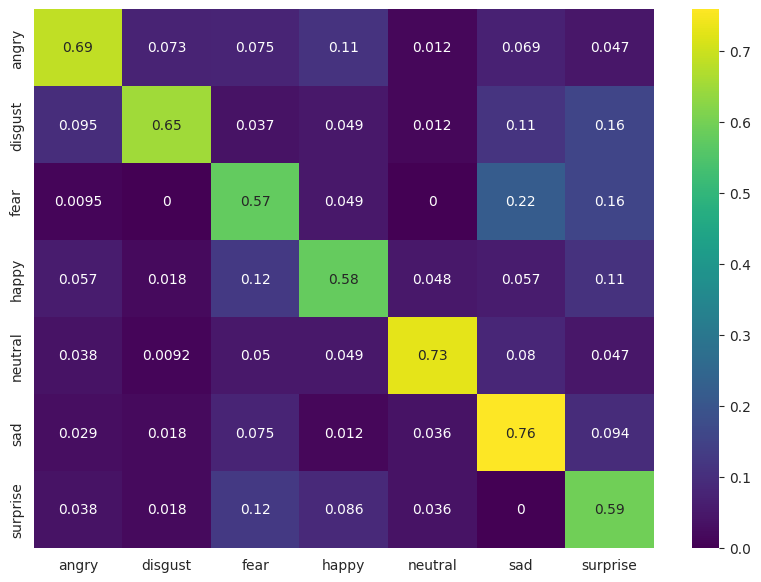

''

In [5]:
import importlib

module_path = str(Path.cwd().parents[0] / "utils")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if module_path not in sys.path:
    sys.path.append(module_path)
import utils.eval_utils as eu

from sklearn.metrics import classification_report

importlib.reload(eu)
print(eu.classificationReport(true, preds, emo_dataset.label_list))
eu.confusion_matrix(true, preds, emo_dataset.label_list)
eu.confustion_matrix_heatmap(true, preds, emo_dataset.label_list)
;
#print(classification_report(true, preds, target_names=emo_dataset.label_list, labels=newSet.emoToId(emo_dataset.label_list)))

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['happy' 'happy' 'surprise' 'happy' 'neutral' 'sad' 'sad' 'neutral'
 'disgust' 'happy' 'sad' 'sad' 'sad' 'neutral' 'neutral' 'surprise'
 'happy' 'happy' 'disgust' 'surprise' 'disgust' 'disgust' 'neutral'
 'neutral' 'sad' 'disgust' 'sad' 'happy' 'surprise' 'neutral' 'neutral'
 'angry' 'surprise' 'fear' 'fear' 'angry' 'fear' 'happy' 'surprise'
 'angry' 'angry' 'disgust' 'disgust' 'sad' 'angry' 'surprise' 'disgust'
 'surprise' 'neutral' 'fear' 'neutral' 'fear' 'angry' 'angry' 'neutral'
 'neutral' 'angry' 'angry' 'happy' 'angry' 'angry' 'angry' 'sad' 'happy'
 'angry' 'sad' 'fear' 'sad' 'angry' 'sad' 'fear' 'disgust' 'fear' 'angry'
 'neutral' 'angry' 'angry' 'disgust' 'fear' 'angry' 'sad' 'happy'
 'neutral' 'angry' 'fear' 'disgust' 'angry' 'fear' 'sad' 'fear' 'angry'
 'sad' 'neutral' 'happy' 'neutral' 'happy' 'neutral' 'happy' 'surprise'
 'neutral' 'angry' 'happy' 'sad' 'angry' 'angry' 'neutral' 'happy'
 'disgust' 'angry' 'happy'

<AxesSubplot: xlabel='test', ylabel='count'>

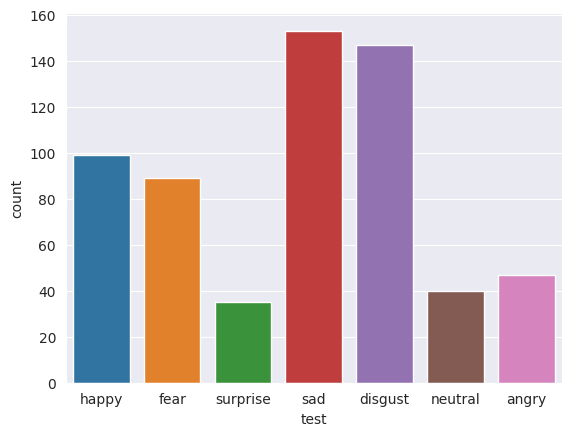

In [20]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
df1 = pd.DataFrame()
# fa



df["test"] = newSet.getEmotionFromId(preds)
df1["test"] = newSet.getEmotionFromId(true)
sns.countplot(x ="test", data= df)


<AxesSubplot: xlabel='test', ylabel='count'>

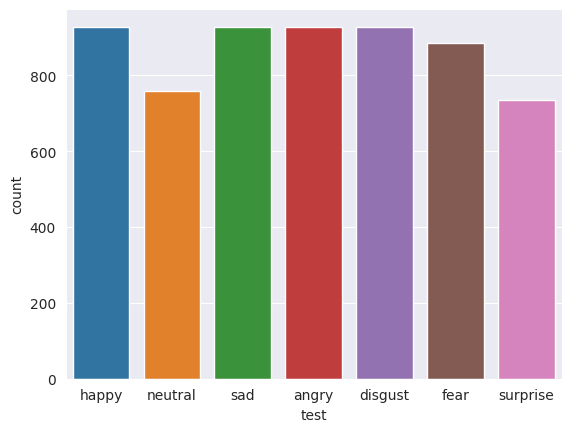

In [62]:
sns.countplot(x ="test", data= df1)

In [84]:
directory_tess="/home/ckwdani/Music/emotionDatasets/unconverted/tess"
directory_cafe="/home/ckwdani/Music/emotionDatasets/converted_mono/cafe"
directory_ravdess="/home/ckwdani/Music/emotionDatasets/converted_mono/RAVDESS Audio_Speech_Actors_01-24"
directory_mesd="/home/ckwdani/Music/emotionDatasets/converted_mono/mesd"
tess = ced.DatasetGeneric(directory=directory_tess, device="cpu", load_dataset=ced.loadTess,)
cafe = ced.DatasetGeneric(directory=directory_cafe, device="cpu", load_dataset=ced.loadCafe,)
ravdess = ced.DatasetGeneric(directory=directory_ravdess, device="cpu", load_dataset=ced.loadRavdess,)
mesd = ced.DatasetGeneric(directory=directory_mesd, device="cpu", load_dataset=ced.loadMesd,)

<AxesSubplot: xlabel='emotion', ylabel='count'>

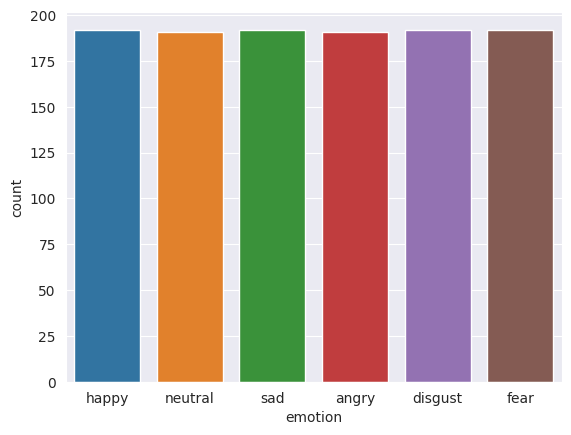

In [85]:
sns.countplot(x=tess.labelcolumn, data=mesd.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

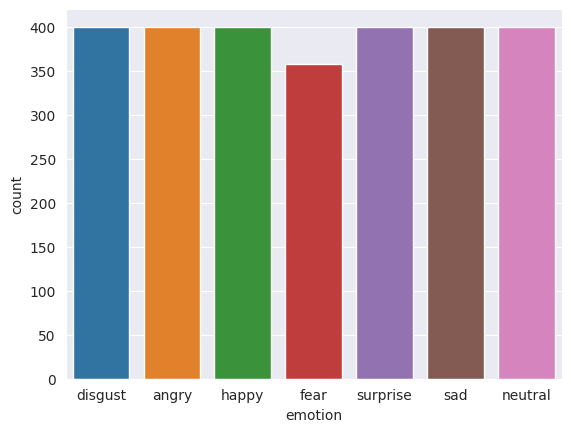

In [86]:
sns.countplot(x=tess.labelcolumn, data=tess.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

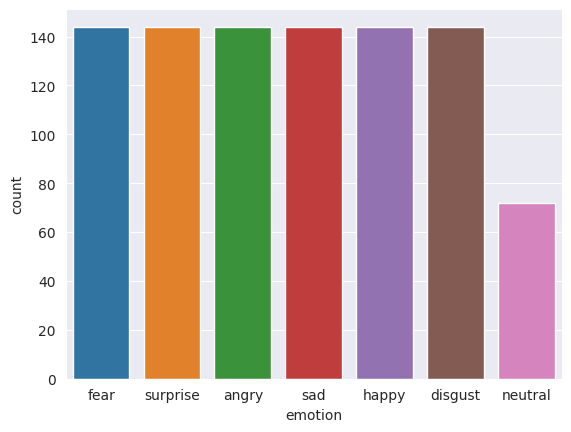

In [82]:
sns.countplot(x=tess.labelcolumn, data=cafe.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

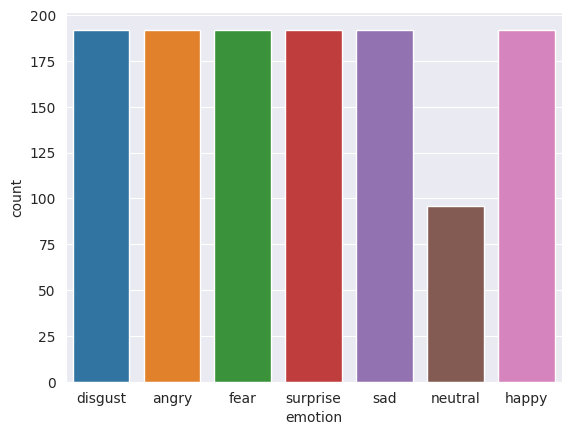

In [87]:
sns.countplot(x=tess.labelcolumn, data=ravdess.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

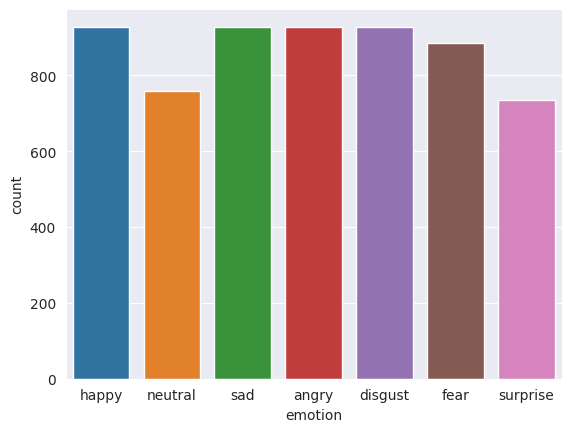

In [88]:
emo_dataset = ced.CombinedEmoDataSet_7_emos(
    directory_tess="/home/ckwdani/Music/emotionDatasets/converted_mono/tess",
    directory_cafe="/home/ckwdani/Music/emotionDatasets/converted_mono/cafe",
    directory_ravdess="/home/ckwdani/Music/emotionDatasets/converted_mono/RAVDESS Audio_Speech_Actors_01-24",
    directory_mesd="/home/ckwdani/Music/emotionDatasets/converted_mono/mesd",
                                             device=device)
sns.countplot(x=emo_dataset.labelcolumn, data=emo_dataset.dataFrame)